# Rasrigin関数(非凸関数)の最小化

Copyright (c) 2022 Tadashi Wadayama  
Released under the MIT license  
https://opensource.org/licenses/mit-license.php

In [1]:
using LinearAlgebra
using Plots
gr()
using Random
Random.seed!(1)
using Flux

### 準備 (グローバル定数の設定)

In [2]:
n = 50
num_itr = 150
K = 50
adam_lr = 5e-6
max_inner = 100

A = 10

10

### Rasrigin関数

In [3]:
function f(x)
    return A*n + sum(x.^2 - A*cos.(2pi*x))
end

f (generic function with 1 method)

### Rasrigin関数の勾配ベクトル

In [4]:
function df(x)
    return 2x + 2pi*A*sin.(2pi*x)
end

df (generic function with 1 method)

### ミニバッチ生成関数

In [5]:
function mini_batch(K)
    xini = 5.0*randn(n,K)
    return xini
end

mini_batch (generic function with 1 method)

### 固定ステップサイズのGD法のMSE

In [6]:
function GD(max_itr, xini, η)
    x = xini
    for i in 1:max_itr
        x = x - η*df(x)
    end
    return x
end

function comp_mse(max_itr, η)
    xini = mini_batch(K)
    x̂ = GD(max_itr, xini, η)
    return norm(x̂)^2/K
end

comp_mse (generic function with 1 method)

┌ Warning: No strict ticks found
└ @ PlotUtils /Users/wadayama/.julia/packages/PlotUtils/VgXdq/src/ticks.jl:294
┌ Warning: No strict ticks found
└ @ PlotUtils /Users/wadayama/.julia/packages/PlotUtils/VgXdq/src/ticks.jl:294


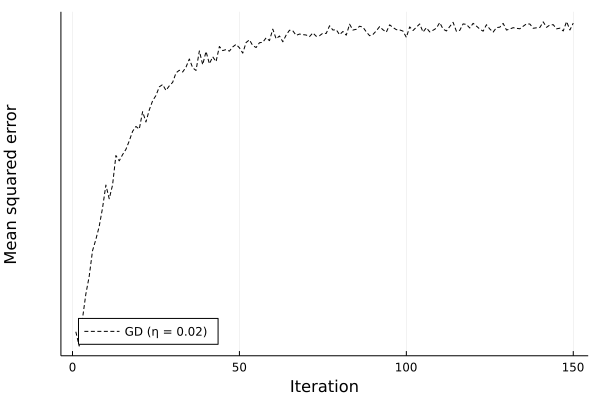

In [7]:
GD_mse = [comp_mse(i, 0.02) for i in 1:num_itr]
plot(1:num_itr, GD_mse, legend=:bottomleft, lw=1, ls=:dash, yscale=:log10, label="GD (η = 0.02)", color=:black,  xlabel="Iteration", ylabel="Mean squared error")

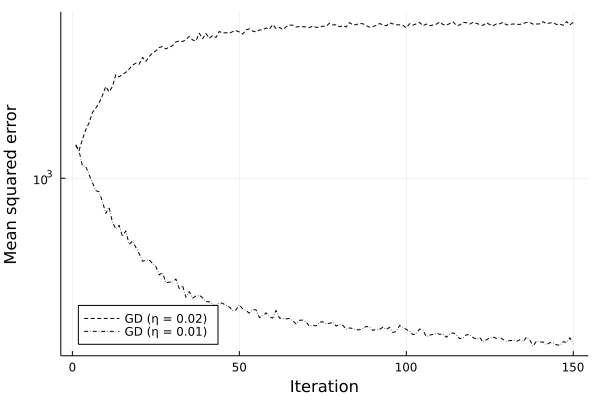

┌ Warning: No strict ticks found
└ @ PlotUtils /Users/wadayama/.julia/packages/PlotUtils/VgXdq/src/ticks.jl:294
┌ Warning: No strict ticks found
└ @ PlotUtils /Users/wadayama/.julia/packages/PlotUtils/VgXdq/src/ticks.jl:294


In [8]:
GD_mse = [comp_mse(i, 0.01) for i in 1:num_itr]
plot!(1:num_itr, GD_mse, lw=1, ls=:dashdot, yscale=:log10, label="GD (η = 0.01)", color=:black,  xlabel="Iteration", ylabel="Mean squared error")

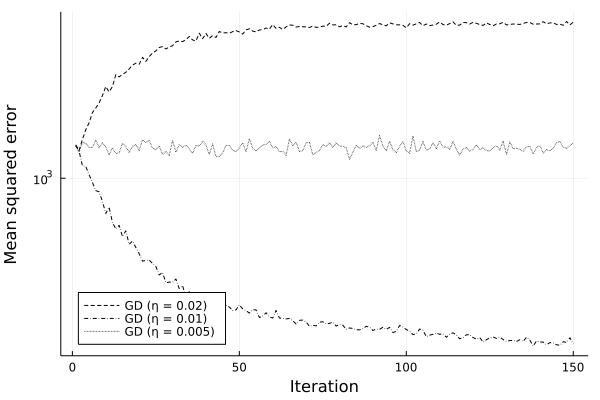

┌ Warning: No strict ticks found
└ @ PlotUtils /Users/wadayama/.julia/packages/PlotUtils/VgXdq/src/ticks.jl:294
┌ Warning: No strict ticks found
└ @ PlotUtils /Users/wadayama/.julia/packages/PlotUtils/VgXdq/src/ticks.jl:294


In [9]:
GD_mse = [comp_mse(i, 0.005) for i in 1:num_itr]
plot!(1:num_itr, GD_mse, lw=1, ls=:dot, yscale=:log10, label="GD (η = 0.005)", color=:black,  xlabel="Iteration", ylabel="Mean squared error")

### DU-GD反復の定義 

In [10]:
function DU_GD(max_itr, xini, η)
    x = xini
    for i in 1:max_itr
        x = x - η[i]*df(x)
    end
    return x
end

DU_GD (generic function with 1 method)

### 損失関数の定義

In [11]:
function loss(x̂)
    return norm(x̂)^2/K
end     

loss (generic function with 1 method)

### 訓練関数の定義

In [12]:
function train(opt, η)
    ps = params(η) 
    for itr in 1:num_itr 
        for i in 1:max_inner 
            x_ini = mini_batch(K)
            gs = gradient(ps) do 
                loss(DU_GD(itr, x_ini, η))
            end
            Flux.Optimise.update!(opt, ps, gs) 
        end
        x_ini = mini_batch(K)
        x̂ = DU_GD(itr, x_ini, η)
        println(itr, " ", loss(x̂))
    end
end

train (generic function with 1 method)

### DU-GDのMSE評価用関数

In [13]:
function comp_mse_DUGD(max_itr, η)
    x_ini = mini_batch(K)
    x̂ = DU_GD(max_itr, x_ini, η)
    return loss(x̂)
end

comp_mse_DUGD (generic function with 1 method)

### 学習過程

1 1214.547672873516
2 1135.0850604669076
3 997.2285067628327
4 893.5694056241612
5 789.2117985906262
6 675.5922103964762
7 627.2564154851913
8 514.8539728016497
9 438.59734242952743
10 413.59225528610943
11 359.92339608451374
12 334.71726304365734
13 287.449569292989
14 258.9646301074233
15 230.0312608826239
16 240.53925868700787
17 217.26018172704255
18 186.67370177077456
19 171.3477222749455
20 163.41823173261622
21 161.12847334090137
22 140.80933548038473
23 152.7492765313567
24 136.02282688160412
25 124.70135769443557
26 116.5725626221707
27 112.45364839376477
28 109.35768777894133
29 106.2687190782807
30 100.36181483118105
31 84.91136988038106
32 88.11673126536567
33 80.13738779612902
34 81.81525441103467
35 76.60219455706054
36 72.1767001275464
37 63.61518843397993
38 72.95702323523355
39 64.53979804321935
40 63.379684553053856
41 59.13488203497937
42 52.536576313172105
43 57.369720523213466
44 48.539756961190285
45 44.84418653493139
46 48.15158469789269
47 43.318423567179025
48 

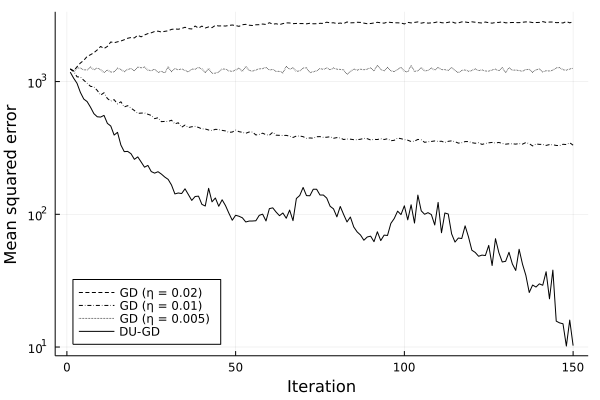

In [14]:
η_train = 0.01ones(num_itr)
opt = ADAM(adam_lr)
train(opt, η_train)
DUGD_mse =[comp_mse_DUGD(i, η_train) for i in 1:num_itr]
plot!(1:num_itr, DUGD_mse, lw=1, label="DU-GD", color=:black)

In [15]:
savefig("Rastrigin.pdf")

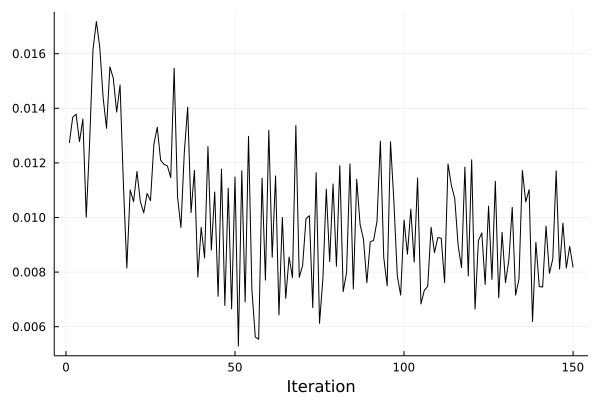

In [16]:
plot(1:num_itr, η_train, color=:black, legend=false, xlabel="Iteration")

In [17]:
savefig("Rastrigin-param.pdf")